In [28]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    buffers = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    
    print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    time_epoch = 0.5
    max_size0 = 0
    max_size1 = 0
    for i in range(20):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    print("CCEH0 max runtime = ",max_size0, "CCEH1 max runtime = ", max_size1)
    

    cceh0 = np.zeros(max_size0)
    
    for i in range(20):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:max_size0]/time_epoch/1024/1024
    time_x = np.array([i for i in np.arange(time_epoch, (max_size0 + 1)*time_epoch, time_epoch)])
    through_x = cceh0_Mops
    
    return time_x, through_x

In [32]:
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_multi/cceh2_dynamic_g1.txt")
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_bufferdist/ccehdual2_g5.txt")
# time_f0, through_f0, time_f1, through_f1 = get_dual_results("./results_multi/cceh2_fixed_g5.txt")

time_d0, through_d0 = get_dual_results("./BufferHashing_Multi/test1")
time_f0, through_f0 = get_dual_results("./BufferHashing_Multi/test2")
time_g0, through_g0 = get_dual_results("./BufferHashing_Multi/test3")
time_h0, through_h0 = get_dual_results("./BufferHashing_Multi/test4")
time_i0, through_i0 = get_dual_results("./BufferHashing_Multi/test5")



     thread  last_done   cur_done  seg_time     time
0      11.0        0.0   470000.0    0.5046   0.5046
1      15.0        0.0   500000.0    0.5067   0.5067
2       7.0        0.0   500000.0    0.5067   0.5067
3      13.0        0.0   470000.0    0.5068   0.5068
4       5.0        0.0   500000.0    0.5069   0.5069
..      ...        ...        ...       ...      ...
514    15.0  9430000.0  9770000.0    0.5104  13.0139
515     2.0  9410000.0  9750000.0    0.5091  13.0143
516     1.0  9380000.0  9720000.0    0.5107  13.0147
517    16.0  9400000.0  9740000.0    0.5119  13.0152
518    18.0  9410000.0  9750000.0    0.5118  13.0153

[519 rows x 5 columns]
CCEH0 max runtime =  26 CCEH1 max runtime =  0
     thread  last_done   cur_done  seg_time     time
0      10.0        0.0   590000.0    0.5009   0.5009
1      17.0        0.0   590000.0    0.5012   0.5012
2      12.0        0.0   590000.0    0.5017   0.5017
3      11.0        0.0   590000.0    0.5020   0.5020
4      14.0        0.0   590

/tmp/ipykernel_1094968/50083143.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1094968/50083143.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  buffers = pd.DataFrame(buffers, columns=['CCEH0_buffe

Text(0, 0.5, 'Throughput (Mops/s)')

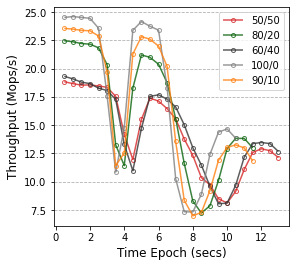

In [33]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['50/50', '80/20', '60/40', '100/0', '90/10']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(time_d0[:], through_d0[:], color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_f0[:], through_f0[:], color=colors[4], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_g0[:], through_g0[:], color=colors[5], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_h0[:], through_h0[:], color=colors[6], marker=markers[2], dashes=dashes[2], label = label[3], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_i0[:], through_i0[:], color=colors[1], marker=markers[2], dashes=dashes[2], label = label[4], alpha=0.8, fillstyle='none', markersize=8)





# if (through_d0.shape[0] > through_d1.shape[0]):
#     thr1 = np.pad(through_d1, (0,through_d0.shape[0] - through_d1.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_d0, thr1+through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
# else:
#     thr0 = np.pad(through_d0, (0,through_d1.shape[0] - through_d0.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_d1, thr0+through_d1, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

# if (through_f0.shape[0] > through_f1.shape[0]):
#     thrb = np.pad(through_f1, (0,through_f0.shape[0] - through_f1.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_f0, thrb+through_f0, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)
# else:
#     thra = np.pad(through_f0, (0,through_f1.shape[0] - through_f0.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_f1, thra+through_f1, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

# fig.savefig("./BufferHashing_Multi/gg.pdf", bbox_inches='tight', pad_inches=0)




# Variable Buffer Size

In [13]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    max_size1 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]
    
    MAX_SIZE = max_size0

    cceh0 = np.zeros(max_size0)
    
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:MAX_SIZE]/0.5/1024/1024
    time_x = np.array([i for i in np.arange(0.5, (MAX_SIZE + 1)/2, 0.5)])
    through_x = cceh0_Mops
    print("Through0: ", sum(through_x), "/", time_x[-1], sum(through_x)/time_x[-1])

    return time_x, through_x

In [14]:
time_d0, through_d0 = get_dual_results("./BufferHashing_Variable_Buffersize/BufferedCCEH_8K.txt")
time_d1, through_d1 = get_dual_results("./BufferHashing_Variable_Buffersize/BufferedCCEH_avg_8K.txt")
time_d2, through_d2 = get_dual_results("./BufferHashing_Variable_Buffersize/BufferedCCEH_avg2814_8K.txt")



Through0:  227.020263671875 / 31.0 7.323234311995968
Through0:  227.1270751953125 / 32.0 7.097721099853516
Through0:  227.34832763671875 / 34.5 6.589806598165761


/tmp/ipykernel_802159/1918236808.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)


Text(0, 0.5, 'Throughput (Mops/s)')

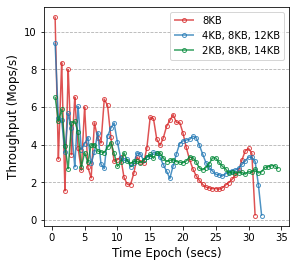

In [15]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', '#008837']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['8KB', '4KB, 8KB, 12KB', '2KB, 8KB, 14KB']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)


ax.plot(time_d0, through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_d1, through_d1, color=colors[2], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_d2, through_d2, color=colors[6], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

# ax.plot(time_rec0, through_rec0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
# ax.plot(time_frec0, through_frec0, color=colors[2], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

# fig.savefig("./variable_buffersize/test.pdf", bbox_inches='tight', pad_inches=0)

## Recovery Read Performance Comparison

In [3]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    max_size1 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]
    
    MAX_SIZE = max_size0

    cceh0 = np.zeros(max_size0)
    
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:MAX_SIZE]/0.02/1024/1024
    time_x = [i for i in np.arange(0.02, (MAX_SIZE + 1)*0.02, 0.02)]
    through_x = cceh0_Mops
    print("Through0: ", sum(through_x), "/", time_x[-1], sum(through_x)/time_x[-1])

    return time_x, through_x

In [4]:
# recovery comparison
time_rec0, through_rec0 = get_dual_results("./BufferHashing_Multi/normal_read2.txt")
time_frec0, through_frec0 = get_dual_results("./BufferHashing_Multi/fast_rec_read2.txt")

Through0:  5711.827278137207 / 7.4799999999999995 763.6132724782362
Through0:  5712.961196899414 / 8.879999999999999 643.3514861373214


/tmp/ipykernel_943181/1940408551.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)


511
138


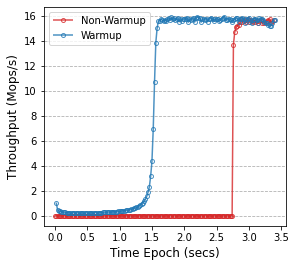

In [13]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', '#008837']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Non-Warmup', 'Warmup']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)

# print(time_rec0, through_rec0)
t = [i for i in np.arange(0, time_rec0[-1] + 2.73, 0.02)]
print(len(t))
print(len(t) - len(through_rec0))

thr = []
for i in range(len(t) - len(through_rec0)):
    thr.append(0)

for i in through_rec0:
    thr.append(i)

node = 170
ax.plot(t[:node], thr[:node], color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_frec0[:node], through_frec0[:node], color=colors[2], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper left")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("./BufferHashing_Multi/Recovery_Warmup.pdf", bbox_inches='tight', pad_inches=0)